# Задача проекта - прогнозирование ежемесячной выручки ресторанов

## Описание данных

### Обозначения признаков


Набор данных содержит следующие сведения:

* `Number_of_Customers` - количество посетителей ресторана
* `Menu_Price` - средние цены на меню в ресторане
* `Marketing_Spend` - расходы на маркетинговую деятельность
* `Cuisine_Type` - тип предлагаемой кухни (итальянская, мексиканская, японская, американская).
* `Average_Customer_Spending` - средние расходы на одного клиента
* `Promotions` - бинарный индикатор (0 или 1), указывающий, проводились ли рекламные акции
* `Reviews` - количество отзывов, полученных рестораном
* `Monthly_Revenue` - ежемесячный доход ресторана, целевая переменная для прогнозирования

## Подготовка и предварительный анализ данных

In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

import statsmodels.api as sm
from scipy import stats as st

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.dummy import DummyRegressor


from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

# снимаем ограничение на количество столбцов
pd.set_option('display.max_columns', None)

# снимаем ограничение на ширину столбцов
pd.set_option('display.max_colwidth', None)

import warnings
warnings.filterwarnings(action='ignore')

In [54]:
RANDOM_STATE = 12345

In [55]:
try:
    df = pd.read_csv('Restaurant_revenue.csv')
except FileNotFoundError:
    print('Файл не найден')

Изучим датасет.

Сначала изучим общую информацию о данных и устраним проблемы в данных, если они будут обнаружены (пропуски, дубликаты, несоответствие типов данных).

In [56]:
df.head()

,Number_of_Customers,Menu_Price,Marketing_Spend,Cuisine_Type,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue
0,61,43.117635,12.663793,Japanese,36.236133,0,45,350.912040
1,24,40.020077,4.577892,Italian,17.952562,0,36,221.319091
2,81,41.981485,4.652911,Japanese,22.600420,1,91,326.529763
3,70,43.005307,4.416053,Italian,18.984098,1,59,348.190573
4,30,17.456199,3.475052,Italian,12.766143,1,30,185.009121


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Number_of_Customers        1000 non-null   int64  
 1   Menu_Price                 1000 non-null   float64
 2   Marketing_Spend            1000 non-null   float64
 3   Cuisine_Type               1000 non-null   object 
 4   Average_Customer_Spending  1000 non-null   float64
 5   Promotions                 1000 non-null   int64  
 6   Reviews                    1000 non-null   int64  
 7   Monthly_Revenue            1000 non-null   float64
dtypes: float64(4), int64(3), object(1)
memory usage: 62.6+ KB


In [58]:
df.isnull().sum()

Number_of_Customers          0
Menu_Price                   0
Marketing_Spend              0
Cuisine_Type                 0
Average_Customer_Spending    0
Promotions                   0
Reviews                      0
Monthly_Revenue              0
dtype: int64

In [59]:
df.duplicated().sum()

0

В датасете с информацией пропущенных значений и дубликатов нет. Все данные имеют нужные типы.

## Исследовательский и статистический анализ данных

### Оценка заведений по типам кухни

Определим все уникальные записи в столбце `Cuisine_Type`.

Определим, какой тип кухни предлагают рестораны и вычислим количество ресторанов каждого вида кухни. 

In [60]:
df_CT = df['Cuisine_Type'].value_counts(normalize=True)
df_CT

Cuisine_Type
Japanese    0.262
American    0.256
Mexican     0.250
Italian     0.232
Name: proportion, dtype: float64

Видим, что примерно одинаковое количество ресторанов в каждой группе.

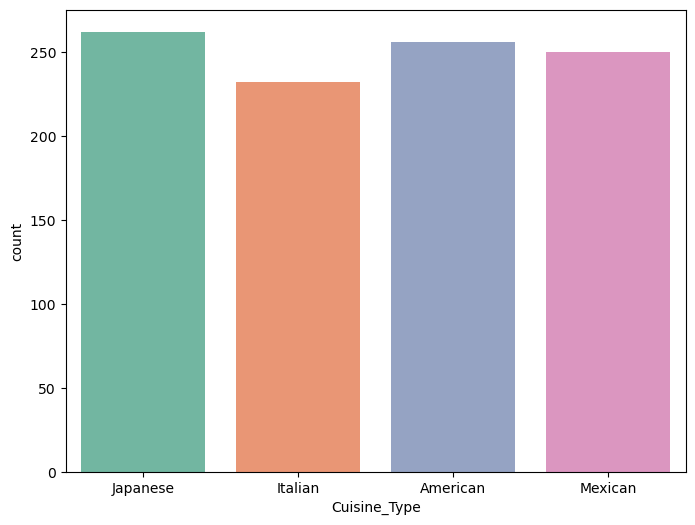

In [61]:
sns.set_palette('Set2')
plt.figure(figsize=(8,6))
sns.countplot(x=df['Cuisine_Type'])


plt.show()

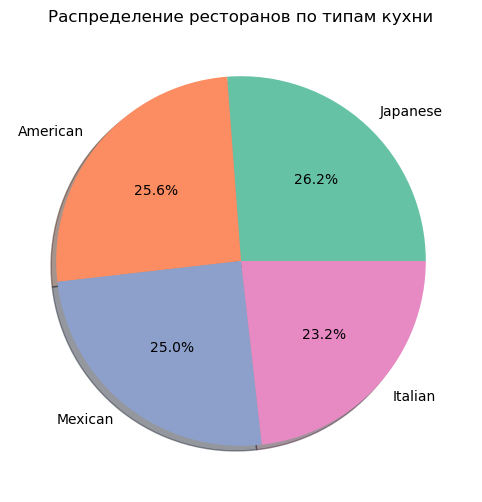

In [62]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.title('Распределение ресторанов по типам кухни')
ax.pie(df_CT.values, labels=df_CT.index, autopct='%1.1f%%', shadow=True)

plt.show()

Видим, что количество ресторанов по типам кухни примерно одинаково.

Оценим, имеются ли различия в ресторанах с разной кухней по числу посетителей, среднему чеку и т.д. Для этого сгруппируем данные по типу кухни и найдем описательную статистику всех количественных показателей

In [63]:
df.groupby('Cuisine_Type').describe().T

Cuisine_Type                       American     Italian    Japanese  \
Number_of_Customers       count  256.000000  232.000000  262.000000   
                          mean    53.445312   52.771552   53.973282   
                          std     26.013966   27.139761   26.441927   
                          min     10.000000   10.000000   10.000000   
                          25%     30.750000   30.000000   31.000000   
                          50%     55.000000   50.000000   59.000000   
                          75%     75.000000   75.250000   74.000000   
                          max     99.000000   99.000000   99.000000   
Menu_Price                count  256.000000  232.000000  262.000000   
                          mean    30.914943   28.922132   30.011624   
                          std     11.080613   11.072902   11.474605   
                          min     10.009501   10.013300   10.049467   
                          25%     22.566445   19.403808   19.751174   
                          50%     31.072958   29.119115   30.105804   
                          75%     40.708798   37.844512   40.063710   
                          max     49.907705   49.974140   49.685333   
Marketing_Spend           count  256.000000  232.000000  262.000000   
                          mean    10.089273   10.079843   10.305762   
                          std      5.649401    6.216160    5.623205   
                          min      0.042077    0.057625    0.003768   
                          25%      5.309099    3.939146    5.397813   
                          50%     10.517831   10.613080   10.635780   
                          75%     14.864521   15.804383   14.850008   
                          max     19.892973   19.994276   19.834852   
Average_Customer_Spending count  256.000000  232.000000  262.000000   
                          mean    30.071254   29.251461   29.784450   
                          std     11.367564   11.633264   11.445853   
                          min     10.037177   10.272588   10.205585   
                          25%     20.155670   19.699094   19.863438   
                          50%     30.792563   27.676848   30.290013   
                          75%     39.768225   39.560984   39.726435   
                          max     49.751359   49.820439   49.900725   
Promotions                count  256.000000  232.000000  262.000000   
                          mean     0.507812    0.500000    0.465649   
                          std      0.500918    0.501081    0.499773   
                          min      0.000000    0.000000    0.000000   
                          25%      0.000000    0.000000    0.000000   
                          50%      1.000000    0.500000    0.000000   
                          75%      1.000000    1.000000    1.000000   
                          max      1.000000    1.000000    1.000000   
Reviews                   count  256.000000  232.000000  262.000000   
                          mean    49.667969   51.823276   50.977099   
                          std     29.654532   28.375478   28.521543   
                          min      0.000000    0.000000    0.000000   
                          25%     23.500000   27.750000   27.000000   
                          50%     47.500000   54.500000   52.000000   
                          75%     76.000000   76.000000   76.750000   
                          max     99.000000   99.000000   99.000000   
Monthly_Revenue           count  256.000000  232.000000  262.000000   
                          mean   269.604825  263.699862  271.700186   
                          std    110.873108  100.384733   98.654120   
                          min    -28.977809  -27.610276   34.494211   
                          25%    187.561999  201.396843  204.959483   
                          50%    271.204821  260.005429  277.851879   
                          75%    354.424106  329.089894  335.752620   
                        

Существенных различий количественные признаки не имеют.

Изучим попарные распределения признаков с помощью диаграмм рассеяния. 

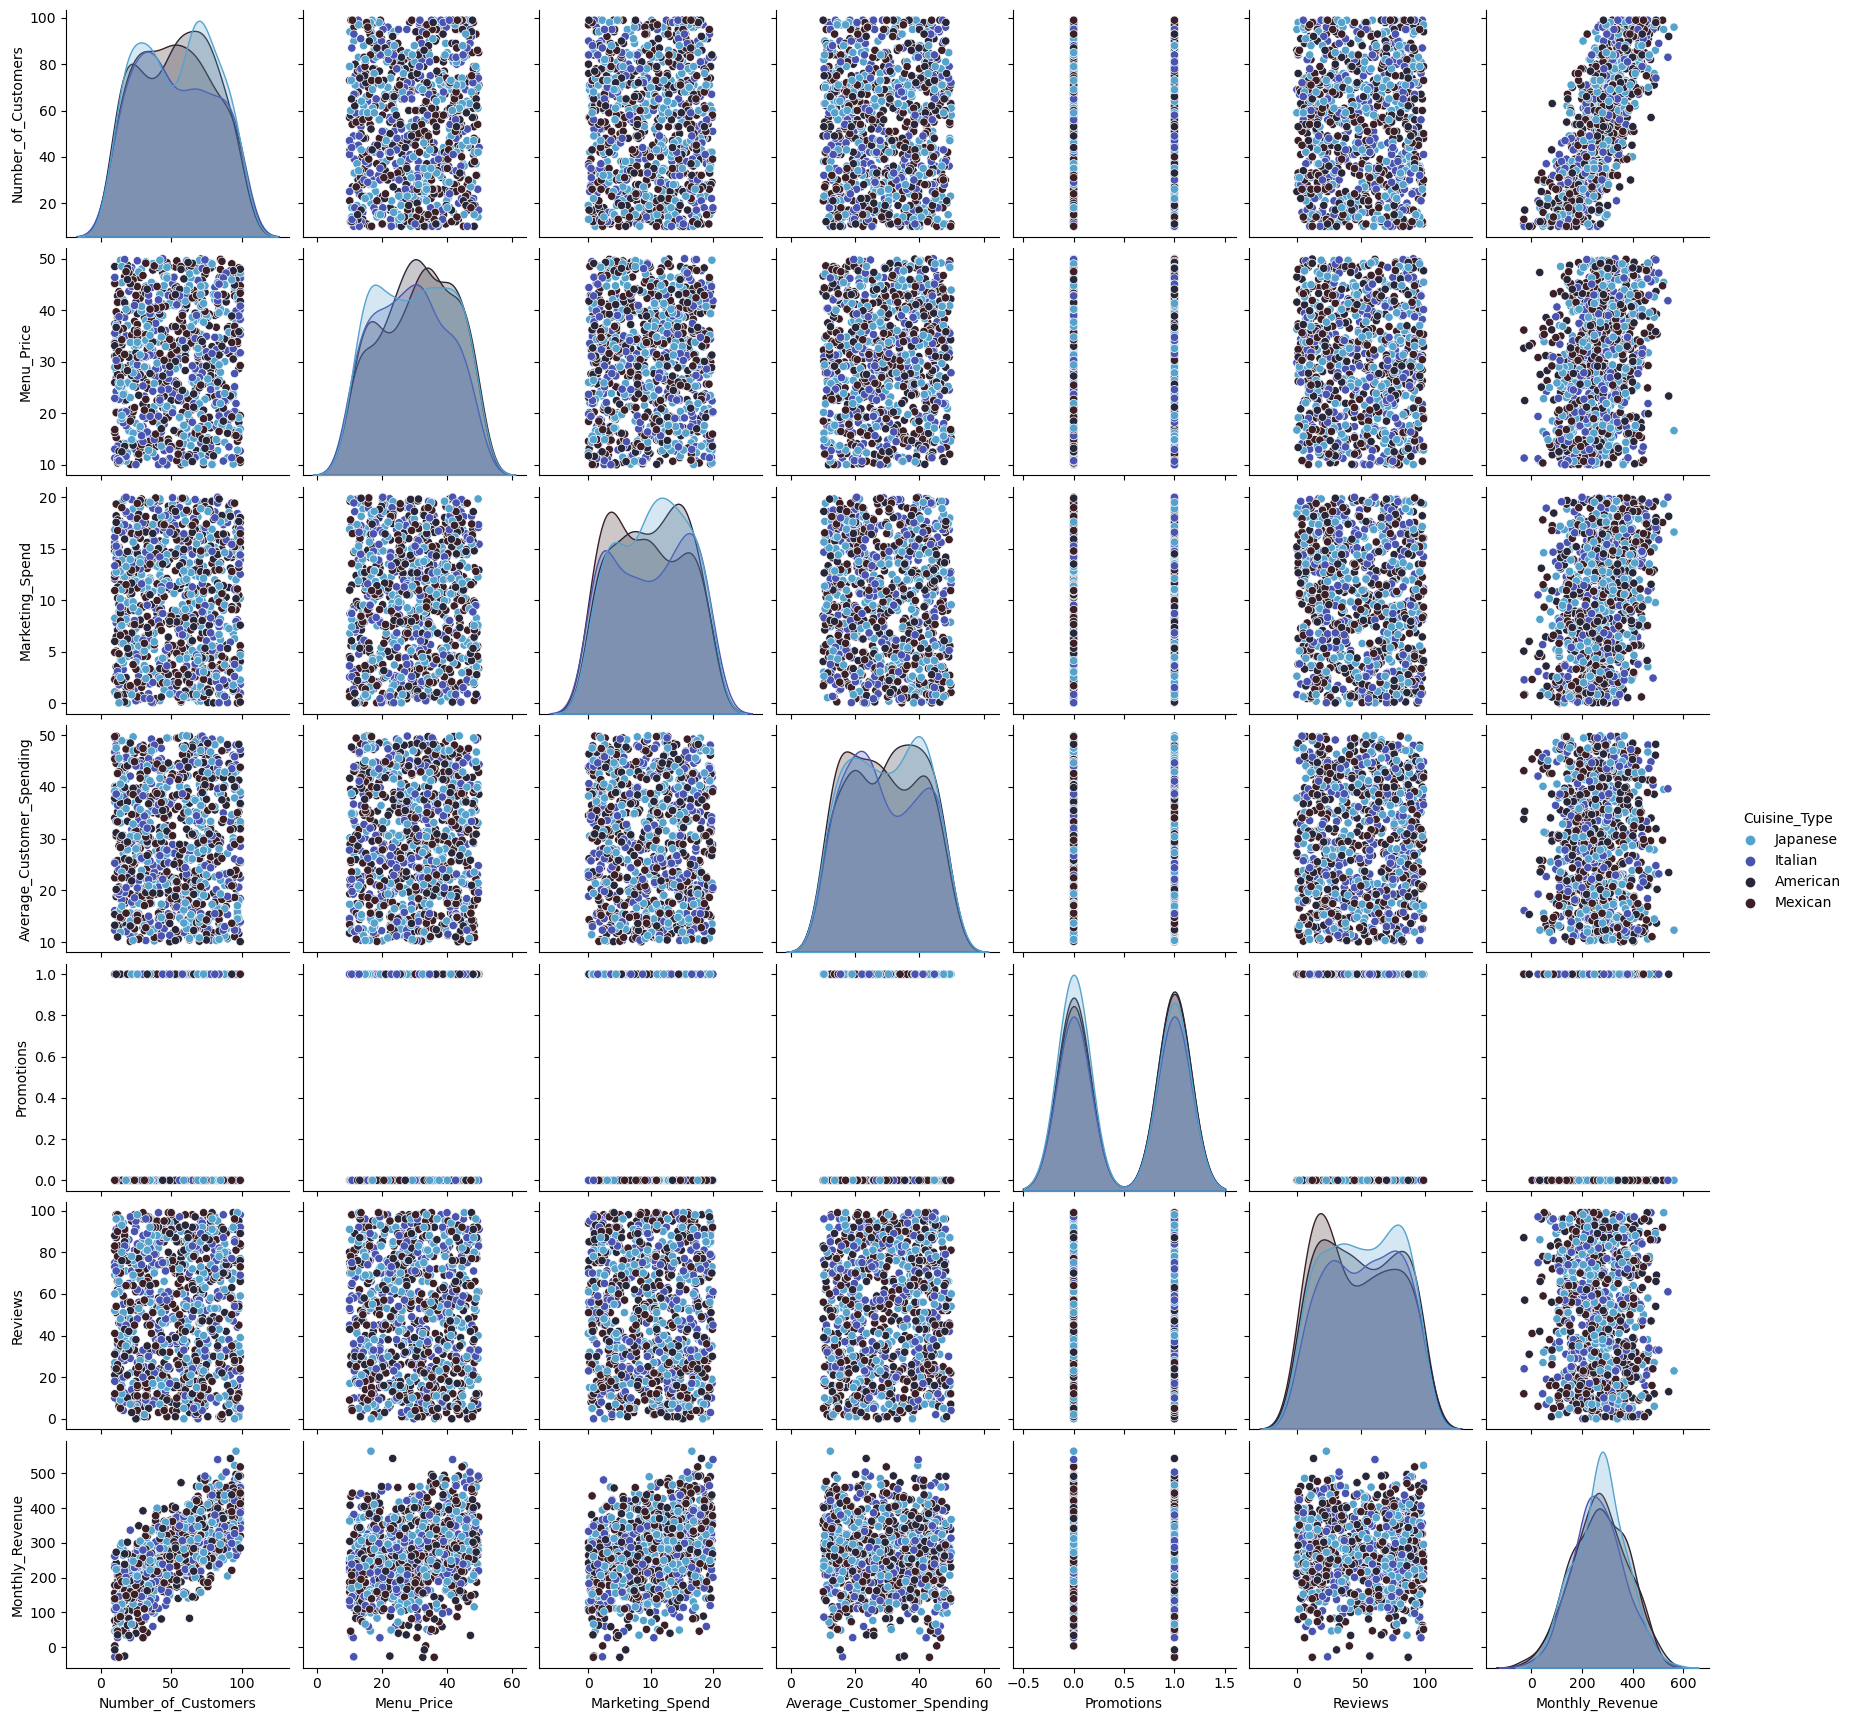

In [64]:
sns.set_palette('icefire')
sns.pairplot(df, hue='Cuisine_Type')

plt.show()

Видим, что большинство признаков имеют похожие распределения, но отличаются числовыми характеристиками. Для некоторых данных характерны смещения влево или вправо.



Построим гистограммы распределения месячной выручки ресторанов. 

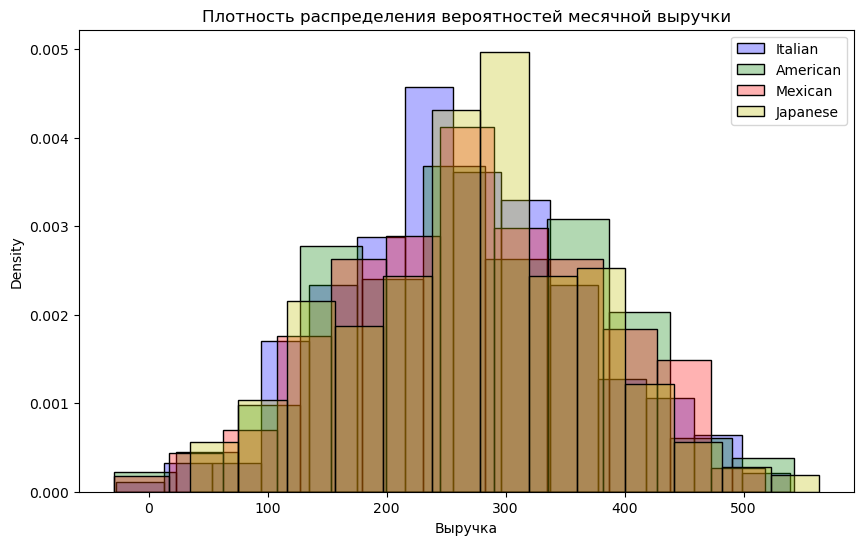

In [65]:
plt.figure(figsize = (10,6))
sns.histplot(df.query('Cuisine_Type == "Italian"')['Monthly_Revenue'], stat = 'density', color = 'b', alpha = 0.3, label = 'Italian')
sns.histplot(df.query('Cuisine_Type == "American"')['Monthly_Revenue'], stat = 'density', color = 'g', alpha = 0.3, label = 'American')
sns.histplot(df.query('Cuisine_Type == "Mexican"')['Monthly_Revenue'], stat = 'density', color = 'r', alpha = 0.3, label = 'Mexican')
sns.histplot(df.query('Cuisine_Type == "Japanese"')['Monthly_Revenue'], stat = 'density', color = 'y', alpha = 0.3, label = 'Japanese')
plt.legend(loc = 'best')
plt.title('Плотность распределения вероятностей месячной выручки')
plt.xlabel('Выручка')
plt.show()

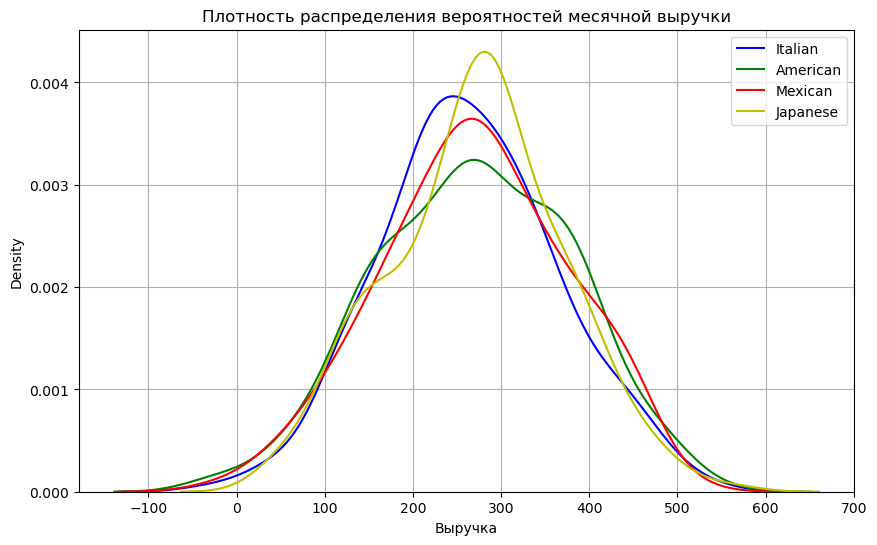

In [66]:
plt.figure(figsize = (10,6))
sns.distplot(df.query('Cuisine_Type == "Italian"')['Monthly_Revenue'], hist = False, color = 'b', label = 'Italian')
sns.distplot(df.query('Cuisine_Type == "American"')['Monthly_Revenue'],  hist = False, color = 'g', label = 'American')
sns.distplot(df.query('Cuisine_Type == "Mexican"')['Monthly_Revenue'], hist = False, color = 'r', label = 'Mexican')
sns.distplot(df.query('Cuisine_Type == "Japanese"')['Monthly_Revenue'], hist = False, color = 'y', label = 'Japanese')

plt.legend(loc = 'best')
plt.title('Плотность распределения вероятностей месячной выручки')
plt.xlabel('Выручка')
plt.grid()
plt.show()

Построим графики плотности распределения всех числовых признаков ресторанов и оценим их распределения. 

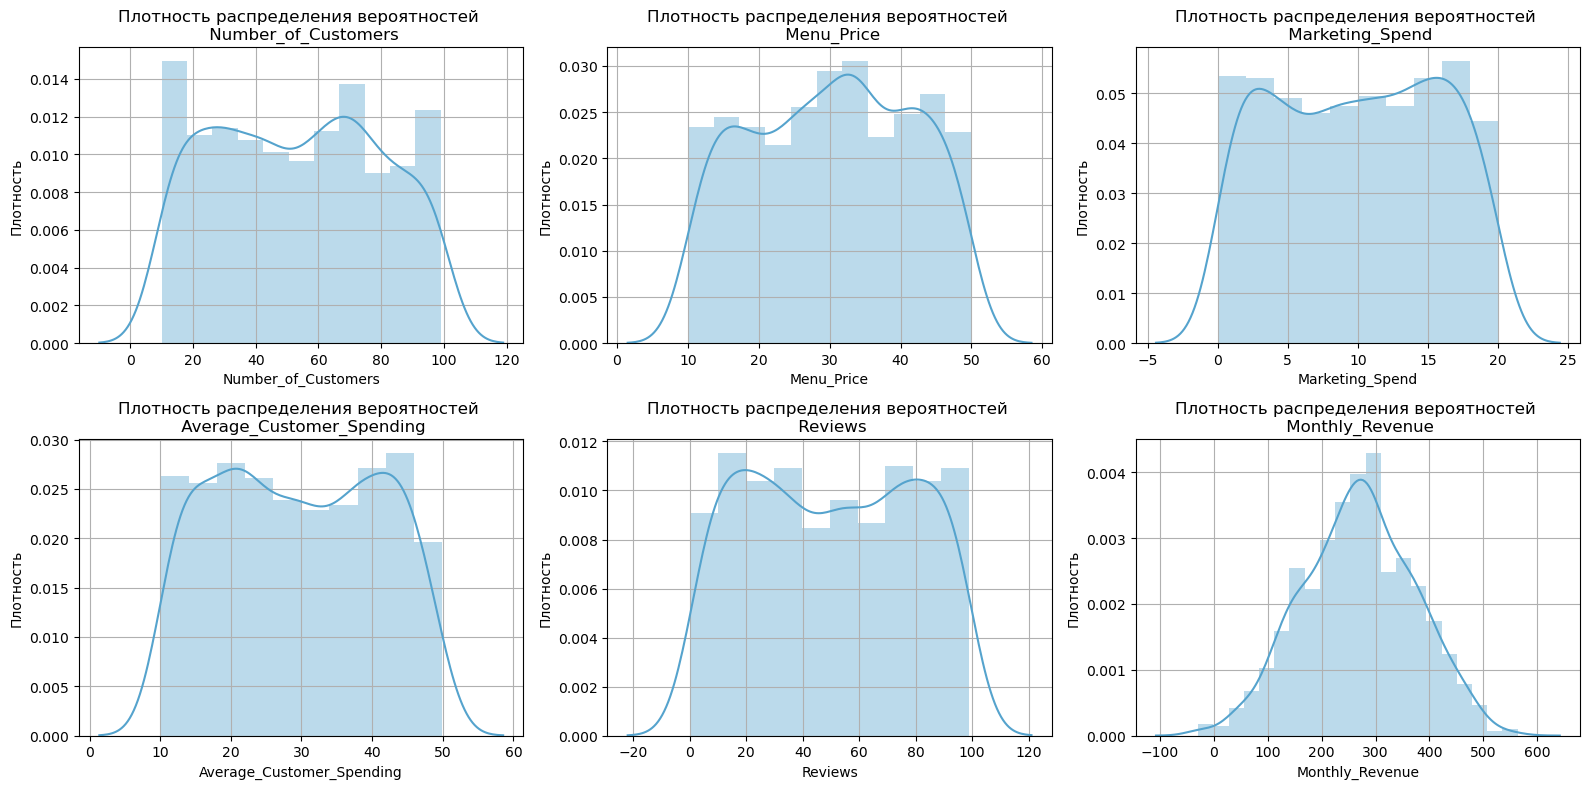

In [67]:
num_col = ['Number_of_Customers', 'Menu_Price', 'Marketing_Spend','Average_Customer_Spending', 'Reviews','Monthly_Revenue']
fig = plt.figure(figsize = (16,8))
for i, name in enumerate(num_col):
    axes = fig.add_subplot(2, 3, i+1)
    plt.title(f"Плотность распределения вероятностей \n {name}", fontsize=12)
    sns.distplot(df[name], hist=True, ax= axes)

    plt.grid()
    plt.xlabel(name, fontsize = 10)
    plt.ylabel('Плотность', fontsize = 10)
    plt.tight_layout()



Распределения всех признаков, кроме месячной выручки, похожи на равномерные. Проверим гипотезу о нормальном распределении признака `Monthly_Revenue`. Применим критерий Шапиро-Уилка. 

In [68]:
st.shapiro(df["Monthly_Revenue"])

ShapiroResult(statistic=0.9975600242614746, pvalue=0.14288349449634552)

In [69]:
def stat_shapiro(data, alpha=0.05):
    results = st.shapiro(data)
    p_value = results[1] 
    print("Alpha: ", alpha)
    print("P-value: {0:.3f}".format(p_value))
    if p_value < alpha:
        print('Нет оснований принять нулевую гипотезу: распределение не является нормальным')
    else:
        print('Нет оснований отвергнуть нулевую гипотезу, распределение нормально')


In [70]:
stat_shapiro(df["Monthly_Revenue"])

Alpha:  0.05
P-value: 0.143
Нет оснований отвергнуть нулевую гипотезу, распределение нормально


Для оценки того, соответствует ли набор данных нормальному распределению, можно построить график `QQ` 

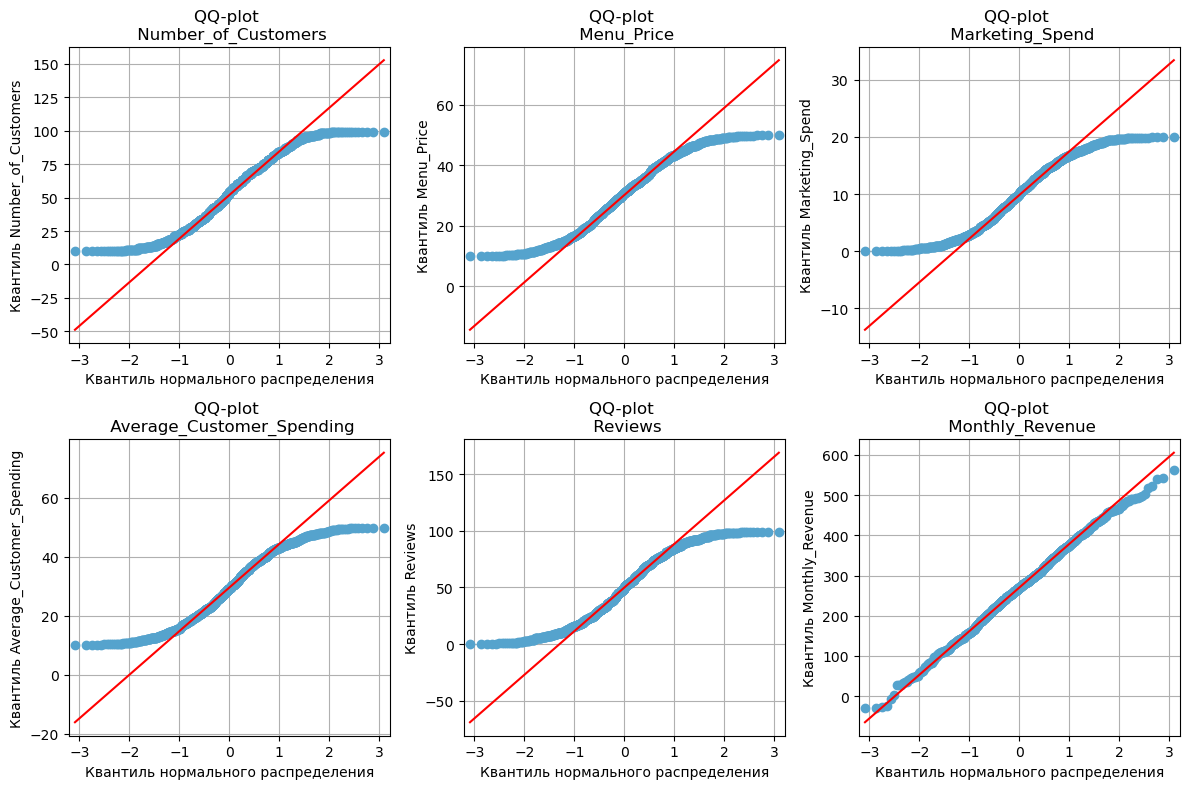

In [71]:
fig = plt.figure(figsize = (12,8))
for i, name in enumerate(num_col):
    axes = fig.add_subplot(2, 3, i+1)
    plt.title(f"QQ-plot \n {name}", fontsize=12)
    sm.qqplot(df[name], line= 'q', ax = axes)

    plt.grid()
    plt.xlabel('Квантиль нормального распределения', fontsize = 10)
    plt.ylabel('Квантиль '+name, fontsize = 10)
    plt.tight_layout()


Мы можем видеть на нашем графике `QQ` для признака `Monthly_Revenue`, что значения данных имеют тенденцию близко следовать к 45-градусной прямой, что означает, что данные, вероятно, нормально распределены.

Оценим нетипичные значения числовых признаков по диаграммам размаха. Построим графики `boxplot`, `violinplot` или `stripplot`.

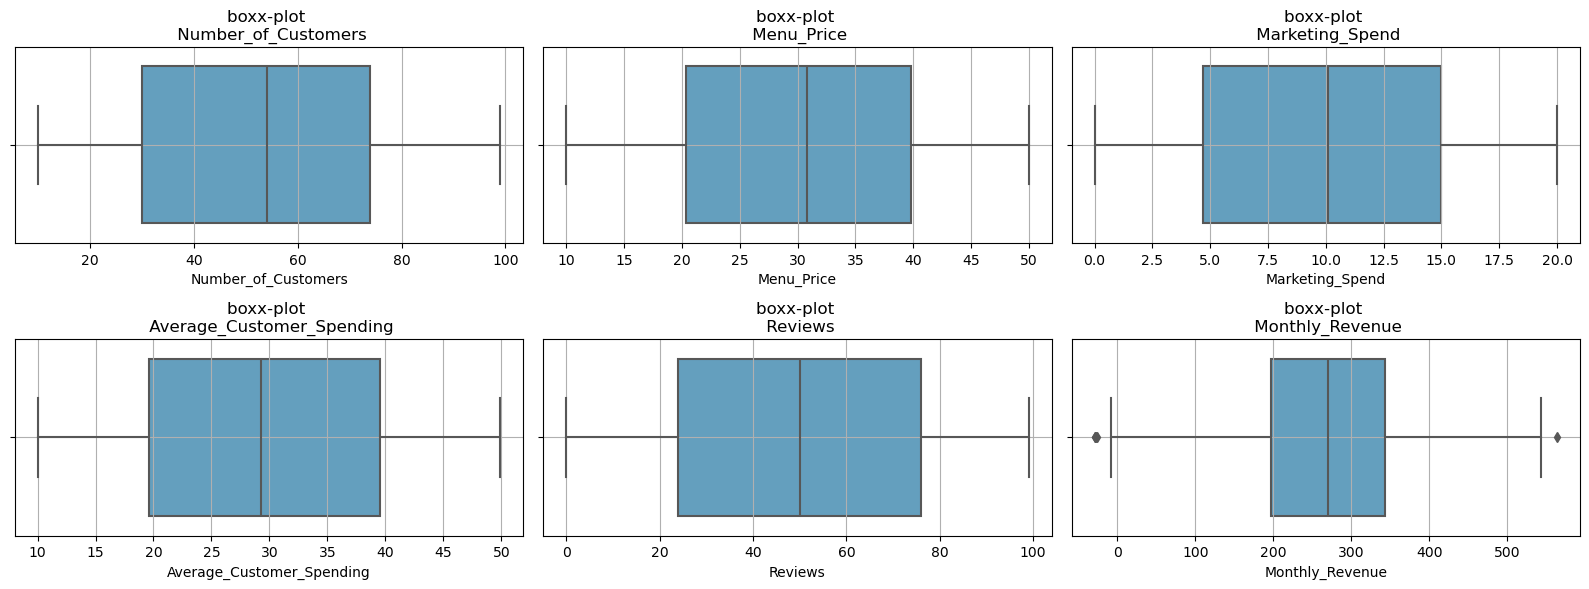

In [72]:
# Построим диаграммы размаха методом boxplot

fig = plt.figure(figsize = (16,6))
for i, name in enumerate(num_col):
    axes = fig.add_subplot(2, 3, i+1)
    plt.title(f"boxx-plot \n {name}", fontsize=12)
    sns.boxplot(x = df[name], ax = axes)

    plt.grid()
    plt.xlabel(name, fontsize = 10)
    plt.tight_layout()


Для значений месячной выручки видим небольшое количество нетипичных отрицательных значений.

In [73]:
df.describe(percentiles= [0.05, 0.25, 0.5, 0.75, 0.95])

,Number_of_Customers,Menu_Price,Marketing_Spend,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,53.271000,30.219120,9.958726,29.477085,0.497000,49.837000,268.724172
std,26.364914,11.278760,5.845586,11.471686,0.500241,29.226334,103.982950
min,10.000000,10.009501,0.003768,10.037177,0.000000,0.000000,-28.977809
5%,13.000000,12.190907,0.882812,12.095320,0.000000,6.000000,101.799445
25%,30.000000,20.396828,4.690724,19.603041,0.000000,24.000000,197.103642
50%,54.000000,30.860614,10.092047,29.251365,0.000000,50.000000,270.213964
75%,74.000000,39.843868,14.992436,39.553220,1.000000,76.000000,343.395793
95%,96.000000,47.976615,18.962904,47.300492,1.000000,95.000000,438.101569
max,99.000000,49.974140,19.994276,49.900725,1.000000,99.000000,563.381332


Видим, что 5%-ный квартиль положительный, поэтому отрицательных значений месячной выручки менее 5%. Определим, границы выбросов.


In [74]:
q_25 = df["Monthly_Revenue"].quantile(0.25)
q_75 = df["Monthly_Revenue"].quantile(0.75)
lower = q_25 - 1.5*(q_75 - q_25)
upper = q_75 + 1.5*(q_75 - q_25)
q_25, q_75, lower,upper

(197.10364179213317, 343.395792775241, -22.334584682528515, 562.8340192499027)

Видим, что нижняя граница выбросов месячной выручки отрицательная. Поэтому устраним все отрицательные записи и исключим данные за пределами верхней границы выбросов.

In [75]:
df_clear = df.query('Monthly_Revenue >= 0 & Monthly_Revenue <= @upper')


In [76]:
df_clear.describe()

,Number_of_Customers,Menu_Price,Marketing_Spend,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue
count,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000
mean,53.434608,30.248379,9.987001,29.498219,0.494970,49.902414,269.898773
std,26.247184,11.283711,5.836555,11.466233,0.500226,29.235191,101.774306
min,10.000000,10.009501,0.003768,10.037177,0.000000,0.000000,3.819308
25%,31.000000,20.443839,4.704846,19.676892,0.000000,24.000000,199.160139
50%,54.000000,30.860614,10.160257,29.251365,0.000000,50.000000,270.527956
75%,74.000000,39.904905,14.995489,39.560178,1.000000,76.000000,343.461651
max,99.000000,49.974140,19.994276,49.900725,1.000000,99.000000,542.467282


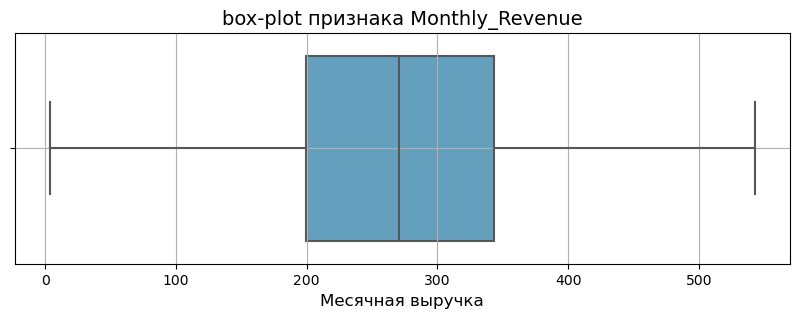

In [77]:
# Построим диаграмму размаха для признака Monthly_Revenue

plt.figure(figsize = (10,3))
plt.title("box-plot признака Monthly_Revenue", fontsize = 14)

sns.boxplot( x= df_clear['Monthly_Revenue'])
plt.grid()
plt.xlabel('Месячная выручка', fontsize = 12)
plt.show()

Все выбросы устранены.

### Изучение корреляционных связей

Построим матрицу парных коэффициентов корреляции

In [78]:
corr = df_clear[num_col].corr()
corr

,Number_of_Customers,Menu_Price,Marketing_Spend,Average_Customer_Spending,Reviews,Monthly_Revenue
Number_of_Customers,1.000000,0.033606,-0.018264,-0.012444,-0.010887,0.742002
Menu_Price,0.033606,1.000000,0.015689,0.017096,0.001947,0.266131
Marketing_Spend,-0.018264,0.015689,1.000000,-0.056750,-0.032851,0.257177
Average_Customer_Spending,-0.012444,0.017096,-0.056750,1.000000,0.052216,-0.033048
Reviews,-0.010887,0.001947,-0.032851,0.052216,1.000000,-0.026690
Monthly_Revenue,0.742002,0.266131,0.257177,-0.033048,-0.026690,1.000000


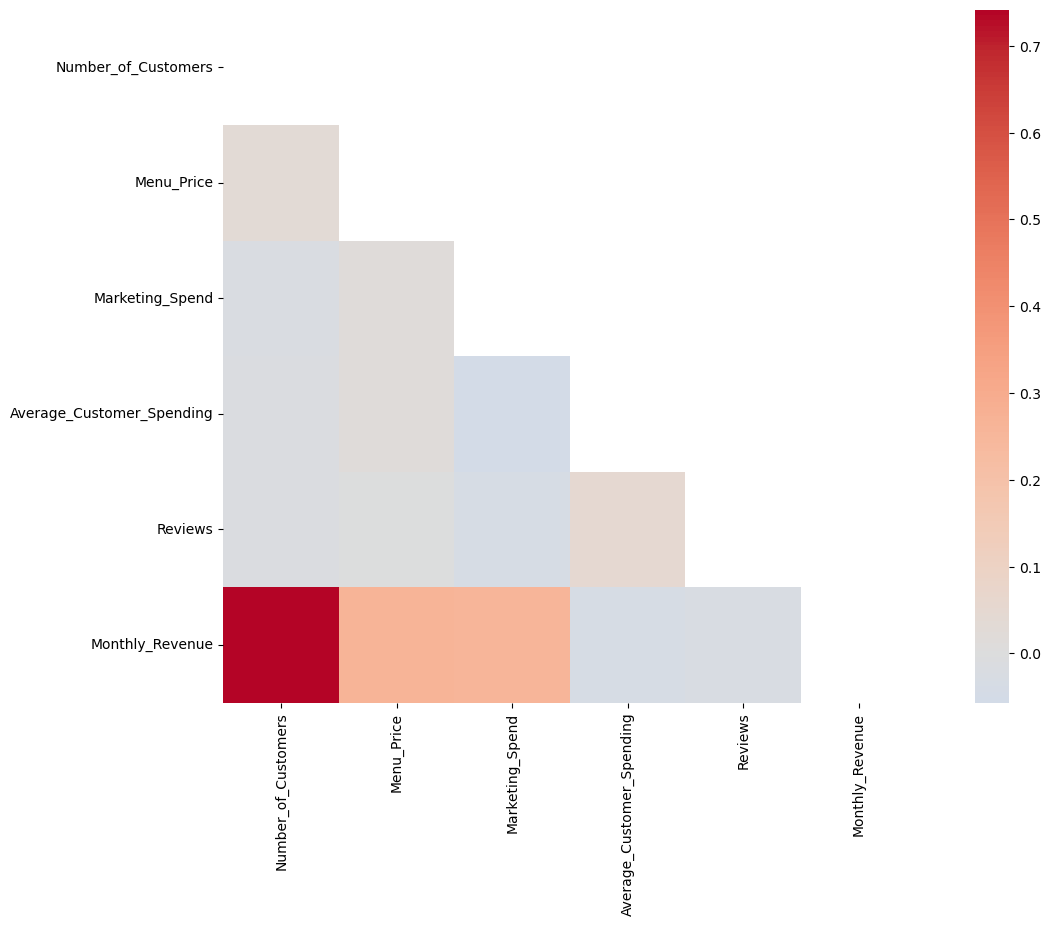

In [79]:
plt.figure(figsize=(15,9))
matrix = np.triu(corr)
sns.heatmap(corr, annot=True,cmap='coolwarm', center = 0, square=True, mask = matrix)

plt.show()

Наиболее тесная линейная связь наблюдается между месячной выручкой и числом посетителей ресторана. Очень слабая линейная связь между месячной выручкой и  средними ценами на меню в ресторане и расходами на маркетинговую деятельность.

Между признаками линейной связи нет.

## Обучение и тестирование моделей ML

### Подготовка данных

In [80]:
X = df_clear.drop(['Monthly_Revenue'], axis = 1)
y = df_clear['Monthly_Revenue']

Разобьем данные на обучающую и тестовую выборки в соотношении 80:20

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= RANDOM_STATE)

print('Размерность обучающего набора', X_train.shape)
print('Размерность тестовой выборки',X_test.shape )

Размерность обучающего набора (795, 7)
Размерность тестовой выборки (199, 7)


In [82]:
# Сделаем копии полученных наборов для выполнения различного рода преобразований
XX_train = X_train.copy()
XX_test = X_test.copy()

Т.к. датасет содержит категориальные признаки, то для применения линейных моделей преобразуем данные методом OHE, введем фиктивные переменные.


In [83]:
# создайте списки с количественными и категориальными признаками
cat_col_names = XX_train.select_dtypes(exclude= "number").columns.tolist()
num_col_names = XX_train.select_dtypes(include= "number").columns.tolist()

ohe = OneHotEncoder(drop = 'first', sparse = False)

X_train_ohe = ohe.fit_transform(XX_train[cat_col_names])
X_test_ohe = ohe.transform(XX_test[cat_col_names])

encoder_col_names = ohe.get_feature_names_out()

X_train_ohe = pd.DataFrame(X_train_ohe, columns = encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns = encoder_col_names)

scaler = StandardScaler()

X_train_scaler = scaler.fit_transform(XX_train[num_col_names])
X_test_scaler = scaler.transform(XX_test[num_col_names])

X_train_scaler = pd.DataFrame(X_train_scaler, columns = num_col_names)
X_test_scaler = pd.DataFrame(X_test_scaler, columns = num_col_names)

XX_train = XX_train.reset_index()
XX_test = XX_test.reset_index()

XX_train = pd.concat([X_train_ohe, X_train_scaler], axis = 1)
XX_test = pd.concat([X_test_ohe, X_test_scaler], axis = 1)


In [84]:
print('Размерность обучающего набора', XX_train.shape)
print('Размерность тестовой выборки', XX_test.shape)

Размерность обучающего набора (795, 9)
Размерность тестовой выборки (199, 9)


### Обучение и оценка адекватности моделей ML

#### Linear Regression 

In [85]:
LR = LinearRegression().fit(XX_train, y_train)

y_predict = LR.predict(XX_test)

R2_LR = r2_score(y_test, y_predict)
print('R2 на тестовой выборке', R2_LR)


R2 на тестовой выборке 0.6592600009057532


In [86]:
LR.coef_

array([ 0.41277554, -2.24642617,  3.29712043, 76.27940959, 23.01028037,
       26.90755518, -1.51947021, -0.09735301, -1.11844476])

In [87]:
# Коэффициенты регрессии
coeff = pd.DataFrame(
     {'Признак' : XX_train.columns,
        'Коэффициент регрессии': LR.coef_
     }).sort_values(by ='Коэффициент регрессии',  ascending = False)
coeff


,Признак,Коэффициент регрессии
3,Number_of_Customers,76.279410
5,Marketing_Spend,26.907555
4,Menu_Price,23.010280
2,Cuisine_Type_Mexican,3.297120
0,Cuisine_Type_Italian,0.412776
7,Promotions,-0.097353
8,Reviews,-1.118445
6,Average_Customer_Spending,-1.519470
1,Cuisine_Type_Japanese,-2.246426


In [88]:
# Свободный член (смещение) регрессии
LR.intercept_

267.903114900295

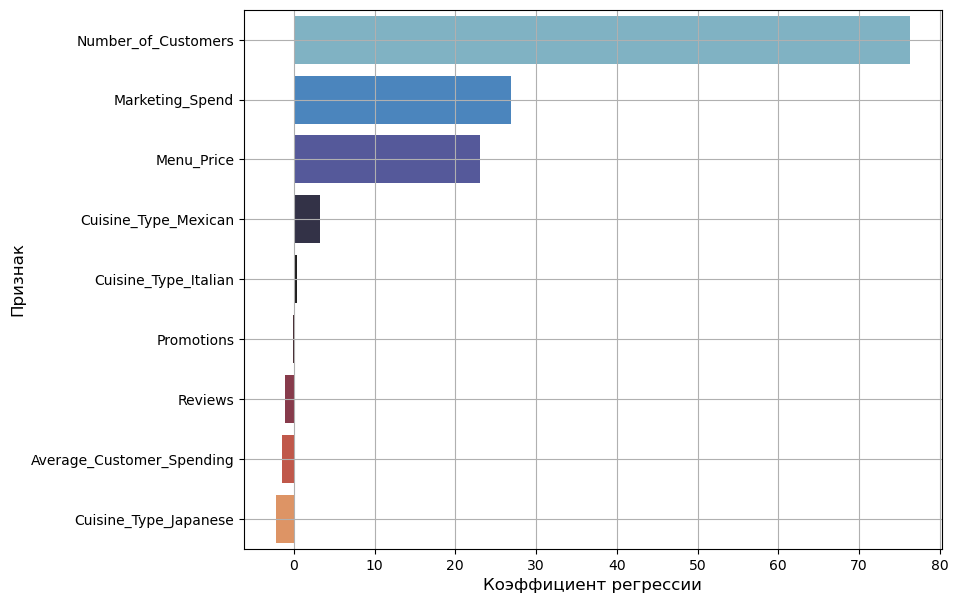

In [89]:
#Построим график коэффициентов регрессии
plt.figure(figsize=(9, 7))
sns.barplot(x = coeff['Коэффициент регрессии'],y = coeff['Признак'], palette= 'icefire' )

plt.xlabel("Коэффициент регрессии", fontsize = 12)
plt.ylabel("Признак", fontsize = 12)
plt.grid()
plt.show()


#### Отбор признаков на основе статистических тестов

Видно, что не все входные признаки хорошо объясняют целевую переменную. А значит, некоторыми можно пренебречь. Чтобы отобрать признаки, используем `SelectKBest` несколько раз с помощью цикла и определим, при каком количестве признаков коэффициент детерминации будет наибольшим.

In [90]:
r2 = []
for i in range(len(XX_train.columns)):
    selector = SelectKBest(f_regression, k = i + 1)
    selector.fit(XX_train, y_train)

    features_names = selector.get_feature_names_out()

    X_train_new = XX_train[list(features_names)]
    X_test_new = XX_test[list(features_names)]

    model = LinearRegression().fit(X_train_new, y_train)

    R2_new = r2_score(y_test, model.predict(X_test_new))


    r2.append(R2_new)

    print('Количество признаков', i+1, 'R2 =', R2_new)

Количество признаков 1 R2 = 0.48646471050437845
Количество признаков 2 R2 = 0.5811943696409252
Количество признаков 3 R2 = 0.6598312532445801
Количество признаков 4 R2 = 0.6597879408087745
Количество признаков 5 R2 = 0.6594284106685233
Количество признаков 6 R2 = 0.6594934821131898
Количество признаков 7 R2 = 0.6594569230915708
Количество признаков 8 R2 = 0.658872706318897
Количество признаков 9 R2 = 0.6592600009057532


При 3 признаках модель прирастает в качестве. Наибольшее значение коэффициент детерминации имеет при 3 признаках. Выясним, какие признаки отобрала линейная регрессия.

In [92]:
selector = SelectKBest(f_regression, k = 3)
selector.fit(XX_train, y_train)

features_names = selector.get_feature_names_out()
features_names

array(['Number_of_Customers', 'Menu_Price', 'Marketing_Spend'],
      dtype=object)

Построим модель линейной регрессии по наиболее значимым 3-м признакам.

In [93]:
LR_new = LinearRegression().fit(XX_train[list(features_names)], y_train)

y_predict = LR_new.predict(XX_test[list(features_names)])

R2_LR_new = r2_score(y_test, y_predict)
print('R2 на тестовой выборке', R2_LR_new)


R2 на тестовой выборке 0.6598312532445801


#### Lasso Regression (Лассо регрессия)



In [94]:
LassoR = Lasso().fit(XX_train, y_train)

y_predict = LassoR.predict(XX_test)

R2_LassoR = r2_score(y_test, y_predict)
print('R2 на тестовой выборке', R2_LassoR)

R2 на тестовой выборке 0.6592770368519292


In [97]:
coeff_Lasso = pd.DataFrame(
     {'Признак' : XX_train.columns,
        'Коэффициент регрессии': LassoR.coef_
     }).sort_values(by ='Коэффициент регрессии',  ascending = False)
coeff_Lasso

,Признак,Коэффициент регрессии
3,Number_of_Customers,75.325683
5,Marketing_Spend,25.870386
4,Menu_Price,22.084647
0,Cuisine_Type_Italian,0.000000
1,Cuisine_Type_Japanese,-0.000000
2,Cuisine_Type_Mexican,0.000000
7,Promotions,0.000000
8,Reviews,-0.338108
6,Average_Customer_Spending,-0.759270


In [96]:
# Свободный член (смещение) регрессии
LassoR.intercept_

268.25205076372055

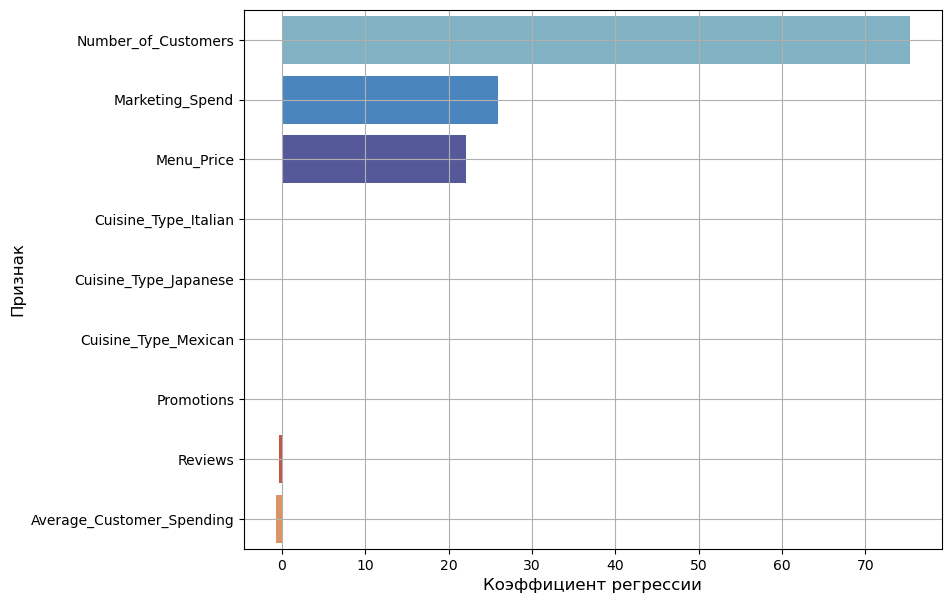

In [98]:
plt.figure(figsize=(9, 7))
sns.barplot(x = coeff_Lasso['Коэффициент регрессии'],y = coeff_Lasso['Признак'], palette= 'icefire' )

plt.xlabel("Коэффициент регрессии", fontsize = 12)
plt.ylabel("Признак", fontsize = 12)
plt.grid()
plt.show()

In [99]:
Results = pd.DataFrame({'Algorithm': ['Linear Regression', 'Lasso Regression'],
                        'R2 score test': [round(R2_LR_new, 3), round(R2_LassoR, 3)]
})
Results

,Algorithm,R2 score test
0,Linear Regression,0.660
1,Lasso Regression,0.659


Видим, что для моделей линейной регрессии метрика `R2` на тестовой выборке остается меньше 0.7.


#### Полиномиальная регрессия

Линейная регрессия улавливает только линейные зависимости, поэтому её можно улучшить, добавив в признаковое описание полиномиальные признаки с помощью полиномизации.

In [100]:
poly = PolynomialFeatures(2)

X_train_poly = poly.fit_transform(XX_train[num_col_names])
X_test_poly = poly.transform(XX_test[num_col_names])

X_train_scalled = pd.DataFrame(scaler.fit_transform(X_train_poly), columns = poly.get_feature_names_out())
X_test_scalled =  pd.DataFrame(scaler.transform(X_test_poly), columns = poly.get_feature_names_out())

X_train_poly = pd.DataFrame()
X_test_poly = pd.DataFrame()

X_train_poly = pd.concat([X_train_ohe, X_train_scalled], axis = 1)
X_test_poly = pd.concat([X_test_ohe, X_test_scalled], axis = 1)


In [101]:
LR_poly = LinearRegression().fit(X_train_poly, y_train)

y_predict = LR_poly.predict(X_test_poly)

R2_LR_poly = r2_score(y_test, y_predict)
print('R2 на тестовой выборке', R2_LR_poly)

R2 на тестовой выборке 0.6392899227123832


In [102]:
#модель лассо-регрессии
Lasso_poly = Lasso().fit(X_train_poly, y_train)

y_predict = Lasso_poly.predict(X_test_poly)

R2_Lasso_poly = r2_score (y_test, y_predict)
print('R2 на тестовой выборке', R2_Lasso_poly)

R2 на тестовой выборке 0.647876716579197


In [103]:
# Коэффициенты регрессии
coeff = pd.DataFrame(
     {'Признак' : X_train_poly.columns,
        'Коэффициент регрессии': Lasso_poly.coef_
     }).sort_values(by ='Коэффициент регрессии',  ascending = False)
coeff


,Признак,Коэффициент регрессии
4,Number_of_Customers,75.617120
6,Marketing_Spend,25.769982
5,Menu_Price,22.426393
27,Average_Customer_Spending Reviews,3.784826
12,Number_of_Customers Marketing_Spend,3.223518
18,Menu_Price Average_Customer_Spending,1.908322
16,Menu_Price^2,0.451754
0,Cuisine_Type_Italian,0.000000
29,Promotions Reviews,-0.000000
28,Promotions^2,-0.000000


In [104]:
Results = pd.DataFrame({'Algorithm': ['Linear Regression', 'Lasso Regression', 'Linear Regression F-test', 'Linear Regression poly', 'Lasso Regression poly'],
                        'R2 score test': [round(R2_LR, 3), round(R2_LassoR, 3), round(R2_LR_new, 3), round(R2_LR_poly, 3), round(R2_Lasso_poly, 3)]
})
Results

,Algorithm,R2 score test
0,Linear Regression,0.659
1,Lasso Regression,0.659
2,Linear Regression F-test,0.660
3,Linear Regression poly,0.639
4,Lasso Regression poly,0.648


Как видим, полиномизация оказалась в данном случае неэффективной

#### Вычисление основных метрик регрессии и исследование остатков модели

In [105]:
model_pred = LR_new.predict(XX_test[list(features_names)])

In [106]:
# Вычислим основные метрики регрессии на тестовом множестве
print("R2 на тестовой выборке:", r2_score(y_test, model_pred))
print("MAE на тестовой выборке:", mean_absolute_error(y_test, model_pred))
print("MAPE на тестовой выборке:", mean_absolute_percentage_error(y_test, model_pred))
print("MSE на тестовой выборке:", mean_squared_error(y_test, model_pred))
print("RMSE на тестовой выборке:", mean_squared_error(y_test, model_pred, squared=False))

R2 на тестовой выборке: 0.6598312532445801
MAE на тестовой выборке: 48.146704728147085
MAPE на тестовой выборке: 0.23544336747013658
MSE на тестовой выборке: 3349.484853844839
RMSE на тестовой выборке: 57.874734157876176


На тестовом наборе коэффициент детерминации $R^2$ = 0.66, что свидетельствует о не достаточно хорошем качестве прогнозирования.

Построим график прогноза и фактических данных в виде диаграммы рассеяния.

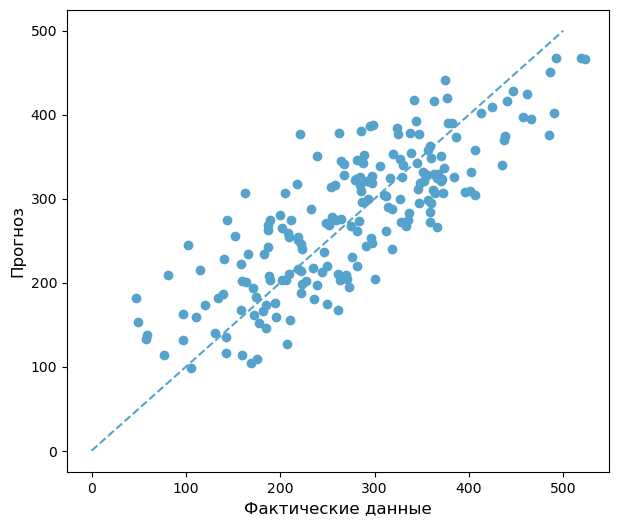

In [107]:
plt.figure(figsize = (7,6))

plt.scatter(x = y_test, y = model_pred)

plt.plot([0, 500], [0, 500], linestyle='--')
plt.xlabel('Фактические данные', fontsize = 12)
plt.ylabel('Прогноз', fontsize = 12)
plt.show()


Изучим остатки регрессии

In [108]:
residual = y_test - model_pred

# Изучим числовые характеристики остатков
residual.describe()

count    199.000000
mean      -3.215639
std       57.931070
min     -155.519155
25%      -46.036500
50%        2.980203
75%       43.920319
max      109.786925
Name: Monthly_Revenue, dtype: float64

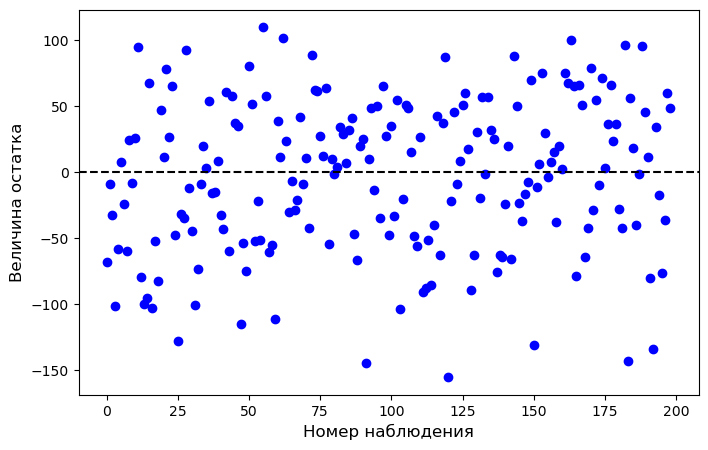

In [109]:
plt.figure(figsize = (8,5))

plt.scatter(x = np.arange(len(residual)), y = residual, color = 'blue')
plt.axhline(y = 0, linestyle = '--', color = 'black')
plt.xlabel('Номер наблюдения', fontsize = 12)
plt.ylabel('Величина остатка', fontsize = 12)
plt.show()

<Figure size 800x500 with 0 Axes>

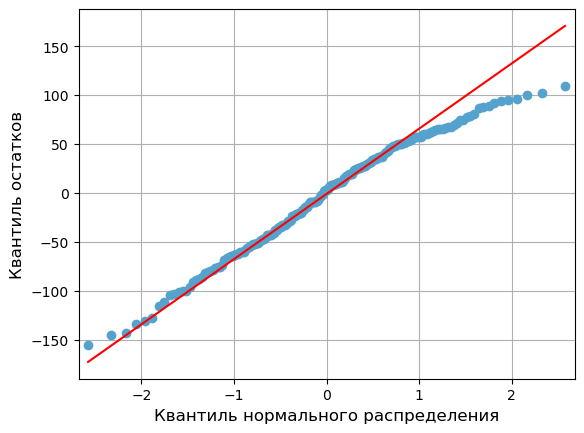

In [110]:
# Построим график QQ
plt.figure(figsize = (8,5))
sm.qqplot(residual, line='q')
plt.grid()
plt.xlabel('Квантиль нормального распределения', fontsize = 12)
plt.ylabel('Квантиль остатков', fontsize = 12)

plt.show()

In [111]:
# Проверим гипотезу о нормальном распределении
stat_shapiro(residual)

Alpha:  0.05
P-value: 0.008
Нет оснований принять нулевую гипотезу: распределение не является нормальным


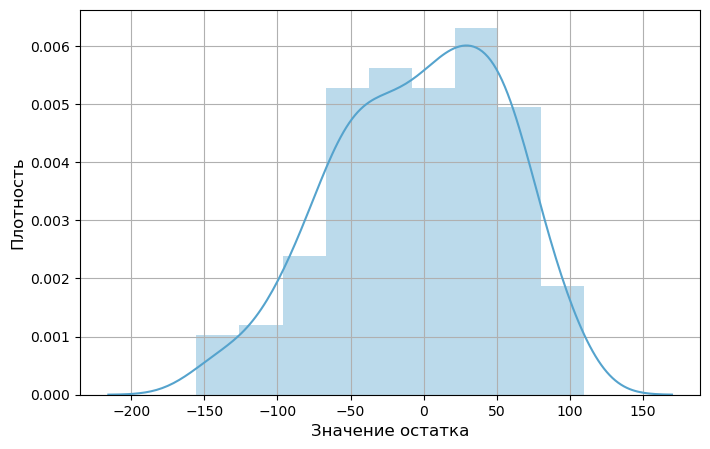

In [112]:
# Построим график плотности распределения вероятностей остатков
plt.figure(figsize = (8,5))
sns.distplot(residual, hist = True)

plt.grid()
plt.xlabel('Значение остатка', fontsize = 12)
plt.ylabel('Плотность', fontsize = 12)

plt.show()

Тест Шапиро-Уилка указал на ненормальность распределения, по гистограмме можно отметить, что распределение остатков ассиметрично и возможно биномиально. Следовательно, модель неудовлетворительного качества. 

### Проверка модели на адекватность. Оценка константной моделью

In [113]:
DummyModel = DummyRegressor().fit(XX_train, y_train)
r2_dummy = r2_score(y_test, DummyModel.predict(XX_test))
print('R2 = ', r2_dummy)

R2 =  -0.006871062747672241


Значение метрики $R^2$ для константной модели на тестовой выборке отрицательна, что свидетельствует о плохом качестве константной модели. Таким образом, построенную модель регрессии можем считать адекватной.